# Studying the influence of atmospheric circulation on upper tropospheric humidity

Production date: 04-04-2025

Produced by: CNRS

## 🌍 Use case: observing the moisture content of the atmosphere and making the link with large scale circulation in the tropics.

## ❓ Quality assessment question:
 - __Can satellite measurements reproduce the known relationship between large-scale circulation and upper tropospheric humidity (UTH)?__

Water vapor in the mid- to upper troposphere, while representing a small fraction of the total column, has
a significant impact on the Earth's radiative budget thanks to its radiative and thermodynamical properties.  In the tropics, the distribution of upper tropospheric humidity (UTH) is primarily controlled by large-scale transport, with influences by storm systems in the deep tropics [[1]] 

The atmospheric circulation is the large-scale movement of air through the Earth's atmosphere, driven by the uneven heating of the planet's surface by the sun. This circulation is responsible for distributing heat and moisture around the globe, shaping weather patterns and climate.
The movement of the air masses influences the distribution of humidity in the upper troposphere. In regions where air rises, such as the  Inter Tropical Convergence Zone, moisture from the lower atmosphere is transported upward, increasing humidity in the upper troposphere.
Conversely, in regions where air sinks, the upper troposphere becomes drier.

This notebook aims to examine the dependency of upper tropospheric humidity on the global atmospheric circulation. Specifically, it seeks to verify if the UTH dataset can reproduce this dependency in agreement with [[2]](https://doi.org/10.1029/2006GL029118). The analysis will compare the dataset's findings with established results to ensure consistency and reliability in representing the atmospheric dynamics.

The analysis is performed using the dataset __Upper tropospheric humidity gridded data from 1999 to present derived from satellite observations__  [[described here]](https://cds.climate.copernicus.eu/datasets/satellite-upper-troposphere-humidity) available on the Climate Data Store of the Copernicus Climate Change Service. 


## 📢 Quality assessment statement 

```{admonition} These are the key outcomes of this assessment
:class: note

- The spatial distribution of Upper Tropospheric Humidity is strongly tied to the large-scale atmospheric circulation: ascending motions moisten the upper troposphere, whereas subsiding motions dry it.

- The analysis is done with one year of monthly data. Over this year, the transition between regimes of large-scale ascent and regimes of large-scale subsidence is consistent with the literature [[2]](https://doi.org/10.1029/2006GL029118).

- The month-to-month variability is small for every regime of circulation, showing the robustness of the link between circulation regimes and UTH. 

- Some discrepancies with the literature arise and are explained by (i) the sampling time of the UTH dataset (9:30 for MetOp-A satellite), while the diurnal cycle of UTH is strong in convective areas, and by (ii) the retrieval method of the UTH of the CDS data record which is not identical to the reference papers. 

- The combination of 
```


The retrieval method for UTH is similar, based on a simple linear equation ([2], [4]):
ln(UTH) = a+b⋅TB
ln(UTH) = a+b⋅TB​
however, the regression coefficients aa and bb are not identical, which may explain part of the differences. Indeed, those parameters are computed using offline radiative transfer codes that have some discrepancies in the water vapor absorption channels (see for instance [6], [7] and [8]).
The results in [2] are based on only two months of data, which could lead to discrepancies when compared to our more comprehensive dataset, even if limited to only one year.
Finally, in this notebook, UTH is observed by the Metop-A satellite at 9:30, while the reference shows UTH data at 15:30. UTH does exhibit a strong diurnal cycle induced by the convective activity such as the growth and decay of storms ([9], [10]), this time difference could potentially affect the comparability of the two datasets.



## 📋 Methodology


The relationship between clear sky geenhouse effect and total column of water vapour is examined using the available datasets from the Climate Data Record (CDR) for sea surface temperature, clouds, and outgoing longwave radiation, detailed below. 

These datasets are daily and the analysis focuses on the __tropical ocean__ over February 2007.

The link between upper tropospheric humidity and large-scale circulation is examined using only the vertical atmospheric motion in the mid-troposphere, at 500hPa (noted $\omega_{500}$) available from the Climate Data Store an detailed below.

The upper tropospheric humidity (UTH) data over the __tropics__ is downloaded for the full year 2007.

Both variables are averaged monthly to smooth out short-term fluctuations caused by convection. The ERA5 data resolution is then reduced to 1 degree to match the resolution of the UTH data. After collocating the monthly values at this resolution, the UTH values are categorized into bins based on the vertical velocities. The distribution of UTH within each bin is presented as a boxplot profile, providing a clear visualization of how UTH varies with changes in vertical velocity. 

The analysis comprises the following steps:

__1. [](data-section-1)__
 - Import the relevant packages.
 - Define the parameters of the analysis and set the dataset requests

__2. [](data-section-2)__
 - Download the variables of interest: Upper tropospheric Humidity is obtained from __Upper tropospheric humidity gridded data from 1999 to present derived from satellite observations__  [[UTH]](https://cds.climate.copernicus.eu/datasets/satellite-upper-troposphere-humidity), Vertical component of wind $\omega_{500}$ is obtained from __ERA5 hourly data on pressure levels from 1940 to present__ [[ERA5]](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview).
 -  ERA5 $\omega_{500}$ is regridded to align with the resolution of UTH and its unit is converted from hPa/s to hPa/day to be consistent with published references.
 -  The datasets are colocated in space and time over the Tropics.
 -  Monthly averages are used.
   
__3. [](Analysis-section-1)__
 -  Maps and histograms of UTH and $\omega_{500}$ are described.
   
__4. [](Plot-and-results)__
 -  The composite of UTH is shown as a function of $\omega_{500}$. The final results are compared with the appropriate references.

## 📈 Analysis and results

(data-section-1)=
### Choose the parameters to use and setup code

#### **Import packages**

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from scipy.stats import linregress
from xhistogram.xarray import histogram

import math
import numpy as np 
from c3s_eqc_automatic_quality_control import diagnostics, download, plot

plt.style.use("seaborn-v0_8-notebook")

import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/helene_brogniez/.cdsapirc")

#### **Define parameters**

This use case is developed for one year of data (2007) and for the tropical belt, restricted to 30$^\circ$S-30$^\circ$N.

In [2]:
# Time
start = "2007-01"
stop = "2007-12"

# Region:
lat_min = -30
lat_max = 30
lon_min = -180
lon_max = 180

#### **Set the data request**

Two datasets are requested :
- Upper Tropospheric Humidity (UTH)
- Vertical atmospheric velocity at 500hPa ($\omega_{500}$)

In [3]:
chunks = {"year": 1, "month": 1}  # nb of years, nb of months
requests = dict()

requests["satellite-upper-troposphere-humidity"] = {
    "sensor_on_satellite": "mhs_on_metop_a",
    "year": ["2007"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "variable": "all",
    "area": [30, -180, -30, 180]
}

requests["reanalysis-era5-pressure-levels"] = {
    "product_type": ["reanalysis"],
    "variable": ["vertical_velocity"],
    "pressure_level": ["500"],
    "year": ["2007"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "time": [
        "00:00", "01:00", "02:00",
        "03:00", "04:00", "05:00",
        "06:00", "07:00", "08:00",
        "09:00", "10:00", "11:00",
        "12:00", "13:00", "14:00",
        "15:00", "16:00", "17:00",
        "18:00", "19:00", "20:00",
        "21:00", "22:00", "23:00"
    ],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [30, -180, -30, 180]
}

(data-section-2)=
### Download the datasets and perform space-time aggregation

The datasets are now downloaded.

In [4]:
datasets = {}

for collection_id in requests :
    request = requests[collection_id]
    datasets[collection_id] =  download.download_and_transform(
                                    collection_id,
                                    download.update_request_date(request | {'area': [lat_max, lon_min, lat_min, lon_max]}, #[N, W, S, E]
                                                                 start, 
                                                                 stop, 
                                                                 stringify_dates=True),
                                        chunks=chunks,
                                    )

100%|██████████| 12/12 [00:00<00:00, 107.70it/s]


#### **Temporal and spatial aggregation**

All data records are provided at different spatial and temporal resolutions : 
- Upper Tropospheric Humidity : 1$^\circ$ / 1-day
- Vertical atmospheric velocity at 500hPa ($\omega_{500}$) : 0.25$^\circ$ / 1-hour
    
Since this is a cross-variable analysis, the study requires to process all the datasets at the same horizontal and temporal resolutions. 

Note that for the UTH data record, two manipulations of the latitude $\times$ longitude grid are done : first a reversal of the latitudes since the data is stored South-to-North (North-to-South for ERA5 $\omega_{500}$), and second a change of the longitude values since the langitudes range from 0° to 360° (-180° to 180° for ERA5 $\omega_{500}$) .

The common spatial aggregation is 1$^\circ$ and the data records are processed at the monthly scale. 

In [5]:
# coarsen datasets to 1° grid / 1-month
ds_tmp = (datasets["satellite-upper-troposphere-humidity"].resample(time='1ME').mean())
ds_uth  = ds_tmp.reindex(latitude=list(reversed(ds_tmp.latitude)))  # latitudes original stored from -90° to + 90°

with xr.set_options(keep_attrs=True):
    ds_uth["longitude"]= (ds_uth["longitude"] + 180) % 360 - 180. # change original 0-360 longitudes into -180 +180 longitudes

ds_omega500 = (datasets["reanalysis-era5-pressure-levels"].resample(time='1ME').mean().coarsen(latitude=4, longitude=4, boundary="pad").mean())

#### **Conversion of unit for vertical velocity**
Most scientific studies focusing on the large-scale atmospheric circulation use __hPa/day__ as the unit for the upward atmospheric wind (see [[3]](https://doi.org/10.1007/s00382-003-0369-6)), since it offers a more meaningful unit at the considered time scale.

In [6]:
## from Pa/s to hPa/day
with xr.set_options(keep_attrs=True):
    ds_omega500["w"] *= 24 * 36

## and the unit in the dataset is changed accordingly
ds_omega500.attrs["units"] = "hPa / day"

In [7]:
## Creation of a dataframe that keeps also the information of the month to study the month-to-month variability
series = {}
months = None
datasets = [
    (ds_omega500["w"], "w"),
    (ds_uth["uth_mean_ascend_descend"], "uth_mean_ascend_descend")
]

for da, name in datasets:
    # sort and stack the data
    stacked = da.sortby(list(da.dims)).stack(index=sorted(da.dims))
    # convert into a serie
    s = stacked.to_series().reset_index()
    # extraction of the month
    s["month"] = s["time"].dt.month
    # storage
    series[name] = s[da.name]
    if months is None:
        months = s["month"]

# Creation of the dataframe
df_monthly = pd.DataFrame(series)
df_monthly["month"] = months.values
# Supress missing values
df_monthly = df_monthly.dropna()

(Analysis-section-1)=
### Overview of the geophysical variables of interest

#### **Upper Tropospheric Humidity**

The Upper Tropospheric Humidity (UTH, in %) is a single-layer geophysical variable provided by EUMETSAT on a 1° regular grid. In general the UTH geophysical variable can be estimated thanks to water vapor absorption channels, both in the microwave (in the 183GHz line) and in the infra-red (in the 6.3 $\mu$m band). 
For the 183GHz microwave channel the UTH is retrieved under all situations, except where measurements are influenced by surface (high orography or extremely dry atmospheric conditions), or when there is a deep convective storm with large ice particules (see [[2]](https://doi.org/10.1029/2006GL029118), [[4]](https://doi.org/10.1029/2007JD009314)).

The UTH data record of the CDS relies on measurements from the 183.31±1 GHz channels of the Advanced Microwave Sounding Unit-B (AMSU-B) and the Microwave Humidity Sounder (MHS) on board the NOAA- and MetOp- satellite series, and the present use case analyses the MHS data of the MetOp-A satellite.

The map below shows the UTH for July 2007.

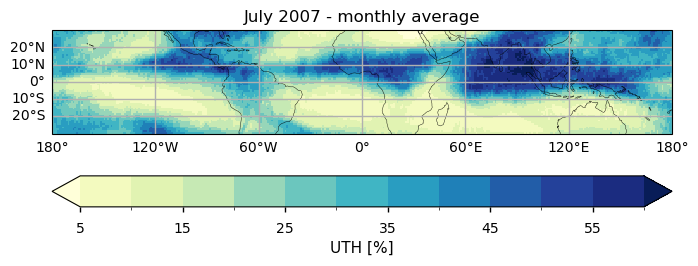

In [8]:
plot.projected_map(
    ds_uth.isel(time=6).compute()["uth_mean_ascend_descend"],
    projection=ccrs.PlateCarree(),
    cmap="YlGnBu",
    robust=True,
    center=False,
    levels=12,
    extend="both",
    cbar_kwargs={
        "orientation": "horizontal",
        "pad": 0.1, 
        "label": "UTH [%]"
    },
    show_stats=False
    )
plt.title("July 2007 - monthly average")
plt.show()

As expected high UTH values are associated to monsoonal regions of strong storms that bring a high amount of moisture: in the Eastern Pacific, over West Africa and in the Indian Ocean and Indonesia (known as the Warm Pool).
On the other side of the UTH range, a drier atmosphere is visible in the continental desert regions, and more generally in both hemispheres, North and South of the Monsoonal regions.

#### **Atmospheric vertical velocity at 500 hPa**

The map below shows the $\omega_{500}$ for the same month of July 2007, overlayed with contours of UTH of the same month.

Text(0.5, 1.0, 'July 2007 - monthly average')

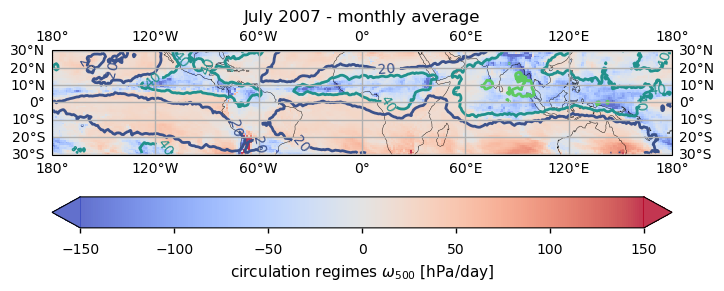

In [9]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))

ds_omega500.isel(time=6, pressure_level=0)["w"].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    robust=True,
    center=False,
    vmin=-150,
    vmax=+150,
    alpha=0.8,
    extend="both",
    cbar_kwargs={
        "orientation": "horizontal",
        "pad": 0.1,
        "label": "circulation regimes $\\omega_{500}$ [hPa/day]",
    },
)

line_c = ds_uth.isel(time=6)["uth_mean_ascend_descend"].plot.contour(
    ax=ax,
    center=False,
    linewidths=2,
    levels=5,
)
ax.clabel(line_c, [20,40], inline=1, fontsize=10)
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
ax.set_title("July 2007 - monthly average")

Negative values of $\omega_{500}$ are ascending motion, while positive values indicate descending motion. 

The contours of UTH, overlayed on the map helps to interpret the structures.

Therefore, and as known by the atmospheric general circulation, ascending motions ($\omega_{500}$ < 0) are regions where storms form by convection. These regions form the moist Inter-Tropical Convergence Zone (ITCZ), a region of strong convergence of the surface winds of the Hadley cells. The convective storms moisten the troposphere by bringing upward the moisture from the boundary layer.

Descending motions ($\omega_{500}$ > 0) are dry regions that are free of storm clouds that are mainly located over the subtropics (near 20°S - 20°S). In these subsidence regions, the air sinks and warms adiabatically without changing its water vapour content, thus decreasing the rate of relative humidity. 
Therefore, $\omega_{500}$ serves to define _large-scale circulation regimes_, as stated in [[3]](https://doi.org/10.1007/s00382-003-0369-6), extremely useful to decompose the dynamical structure of the tropical atmosphere.

The following density histogram illustrates the probability density function (PDF) of $\omega_{500}$ for the full year 2007.

<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
/data/wp5/.tmp/ipykernel_3798047/2564806717.py:18: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('circulation regimes - $\omega_{500}$ [hPa/day]')


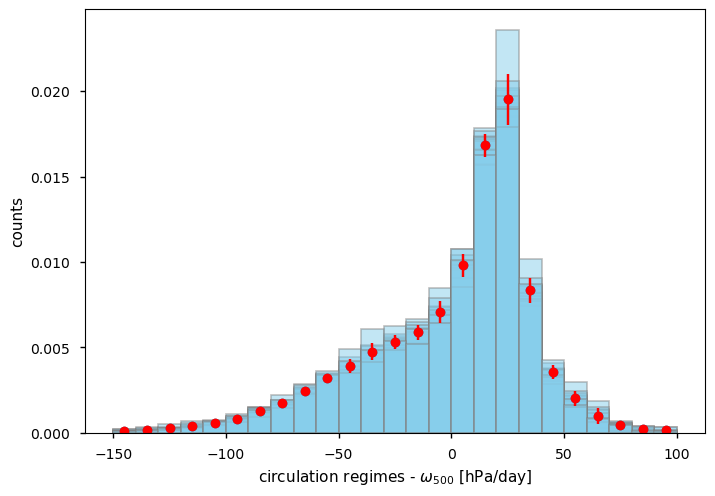

In [91]:
nb=25 ## number of bins for the histogram
nm=12 ## number of months : 1 year
pdf = []
for i in range(nm):
    data = ds_omega500.isel(time=i, pressure_level=0).compute().w.data.flatten()
    entries, bin_edges, _ = plt.hist(data, bins=nb, range=(-150,100), color="skyblue", edgecolor='grey', linewidth=1.2, density=True, alpha=0.5)
    pdf.append(entries)

pdf=np.array(pdf)
mean_pdf = pdf.mean(axis=0,keepdims=True) ## mean of monthly pdfs
std_pdf = pdf.std(axis=0,keepdims=True)   ## standard deviation from monthly pdfs
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.plot(bin_centers, mean_pdf[0,], "o")
plt.errorbar(bin_centers, mean_pdf[0,], yerr = std_pdf, fmt ='o', color="red")

plt.ylabel('counts')
plt.xlabel('circulation regimes - $\omega_{500}$ [hPa/day]')
plt.show()

*Figure 1: Probability density function (PDF) of the $\omega_{500}$ for the year 2007 in the tropics (30°N - 30°S). Each PDF is for one month. The red marks and vertical bars show the average PDF and the standard deviation, considered as the uncertainty, within each 10-hPa bin.*

Overall the distribution of $\omega_{500}$ is negatively skewed, with a peak around 20 hPa/day. This peak, compliant with [[3]](https://doi.org/10.1007/s00382-003-0369-6), shows that the tropics are dominated by a weak subsiding motion found in the subtropics and in the western parts of the ocean basins.
The negative tail reflects the magnitude of vertical motions within clouds.
The small error bars highlight the small temporal variability in the occurrence of each bins of $\omega_{500}$ throughout the year.

(Plot-and-results)=
### Plot and description of the results

#### Variation of UTH with the vertical velocity at 500hPa

The decomposition of the tropical atmosphere into bins of $\omega_{500}$ gives a framework to look at the variability of the tropical atmosphere upon purely dynamical characteristics.
Then, for a given latitude$\times$longitude$\times$month the UTH is associated to a value of $\omega_{500}$. This framework allows to study the distribution of UTH upon dynamical condiseration only.

The entire year 2007 is considered as a whole. 

<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\o'
/data/wp5/.tmp/ipykernel_3798047/2936937811.py:25: SyntaxWarning: invalid escape sequence '\o'
  xlabel="circulation regimes - $\omega_{500}$ [hPa/day]",


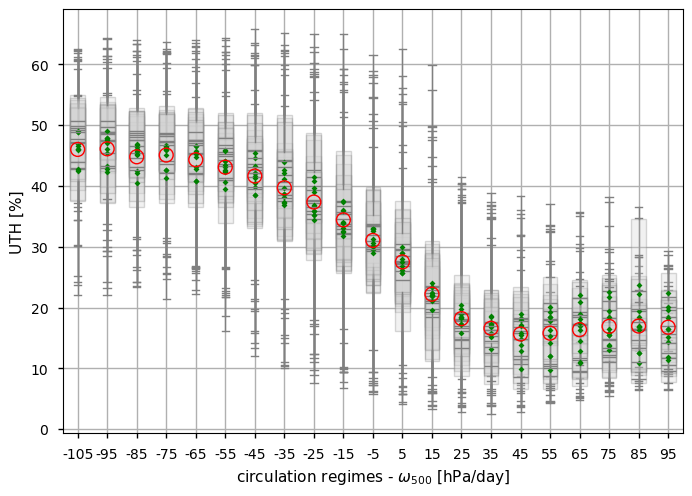

In [109]:
bin_edges = np.array(range(-110, 110, 10))
bin_labels = pd.Series(bin_edges).rolling(2).mean()[1:].astype(int).astype(str)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

nm=12 ## number of months : 1 year
total_bin_means = []

for i in range(nm):
    df_extract = df_monthly.loc[df_monthly["month"]==i]
    grouper = pd.cut(df_extract["w"], bin_edges)
    ## mean within each bin
    bin_means = df_extract.groupby(grouper, observed=False)["uth_mean_ascend_descend"].mean()
    total_bin_means.append(bin_means)
    ax = df_extract.groupby(grouper, observed=False).boxplot(
        subplots=False,
        column="uth_mean_ascend_descend",
        showfliers=False,
        patch_artist=True,
        showmeans=True,
        medianprops={"linewidth": 1, "color": "grey"},
        meanprops={"marker": "D", "markeredgecolor": "grey", "markerfacecolor": "green", "markersize": 3},
        whiskerprops={"color": "grey"},
        capprops={"color": "grey"},
        boxprops={"color": "grey", "facecolor": "lightgrey", "alpha":0.3},
        xlabel="circulation regimes - $\omega_{500}$ [hPa/day]",
        ylabel="UTH [%]",
        grid=True,
        positions=range(len(bin_labels)),
    )
    ax.set(xticklabels=[])
    
df_total_bin_means = pd.DataFrame(total_bin_means)
mean_of_means = df_total_bin_means.mean(axis=0)

_= ax.set_xticks(range(len(bin_labels)))
_= ax.set_xticklabels(bin_labels)

for pos, mean_val in enumerate(mean_of_means):
    ax.scatter(pos, mean_val, color='red', s=100, marker='o', facecolors='none', linewidth=1.0, zorder=3)

*Figure 2: Distribution of UTH for different circulation regimes defined by 10-hPa bins of $\omega_{500}$, for each month of year 2007. The gray boxes represent the interquartiles, the median are in grey. The green symbols represent the mean of the UTH of each bin of the given months. The red circles are the mean of the means within each bin.*

Overall the results are in agreement with Figure 2 of [[2]](https://doi.org/10.1029/2006GL029118), which compare the retrieved monthly UTH from NOAA-16 to the vertical velocity.
In agreement with this study, the UTH shows a sharp transition from convergence regions to subsidence regions. The UTH value remains stable at around 20% over regions where $\omega_{500}$ exceeds 30 hPa/day. 
Figure 2 shows that there is little month-to-month variability within a given circulation regime, the largest variability being observed in the extreme ascending regimes, for $\omega_{500}$ > 55 hPa/day. This is essentially explained by the small occurrence of such regimes, as visible on Figure 1.

The discrepancy between the present results and the reference study lies within the UTH distribution and can be explained by the factors outlined below.

The UTH reaches a plateau of maximum value of approximately 45-50% when upward motions reach -70 hPa/day. The reference reports slightly lower values, which still fall within the UTH distribution observed in this study. The discrepancies between these results and those presented in [[2]](https://doi.org/10.1029/2006GL029118) can arise from the following reasons:

- The retrieval method for UTH is similar, based on a simple linear equation ([[2]](https://doi.org/10.1029/2006GL029118), [[4]](https://doi.org/10.1029/2007JD009314)): $$\text{ln}(UTH) = a + b \cdot T_B$$ however, the regression coefficients $a$ and $b$ are not identical, which may explain part of the differences. Indeed, those parameters are computed using offline radiative transfer codes that have some discrepancies in the water vapor absorption channels (see for instance [[6]](https://acp.copernicus.org/articles/14/11129/2014/), [[7]](https://www.wcrp-climate.org/resources/wcrp-publications/1095-pub-2017) and [[8]](https://journals.ametsoc.org/view/journals/bams/81/4/1520-0477_2000_081_0797_aiorcf_2_3_co_2.xml)).
- The results in [[2]](https://doi.org/10.1029/2006GL029118) are based on only two months of data, which could lead to discrepancies when compared to our more comprehensive dataset, even if limited to only one year.
- Finally, in this notebook, UTH is observed by the Metop-A satellite at 9:30, while the reference shows UTH data at 15:30. UTH does exhibit a strong diurnal cycle induced by the convective activity such as the growth and decay of storms ([[9]](https://acp.copernicus.org/articles/7/2489/2007/acp-7-2489-2007-discussion.html), [[10]](https://doi.org/10.3390/rs8040325)), this time difference could potentially affect the comparability of the two datasets.

## ℹ️ If you want to know more
### Key resources
Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entries for the data used is:
- Upper tropospheric humidity gridded data from 1999 to present derived from satellite observations:
https://cds.climate.copernicus.eu/datasets/satellite-upper-troposphere-humidity

- ERA5 hourly data on pressure levels from 1940 to present:
https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels

Code libraries used:
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [B-Open](https://www.bopen.eu/)

And more resources on tropical atmosphere, large-scale circulation and upper tropospheric humidity :

- https://www.nature.com/scitable/knowledge/library/tropical-weather-84224797/

- Additonal scientific articles on Upper Tropospheric Humidity :

  - IPCC Assessment Report 4, 2007 : 3.4.2.2 Upper Tropospheric Water Vapor, in WG1: The Physical Science Basis, https://archive.ipcc.ch/publications_and_data/ar4/wg1/en/ch3s3-4-2-2.html
  - Shi, L., Schreck III, C. J., John, V. O., Chung, E.-S., Lang, T., Buehler, S. A., and Soden, B. J., 2022: Assessing the consistency of satellite-derived upper tropospheric humidity measurements, Atmos. Meas. Tech., 15, 6949–6963, https://doi.org/10.5194/amt-15-6949-2022
  - Chung E., B. Soden, B.J. Sohn, and L. Shi, 2014: Upper-tropospheric moistening in response to anthropogenic warming, Proc. Natl. Acad. Sci. U.S.A. 111 (32) 11636-11641, https://doi.org/10.1073/pnas.1409659111  

### References

[[1]](https://doi.org/abs/10.1029/97GL03563) Pierrehumbert R. T (1998), Lateral mixing as a source of subtropical water vapor, Geophys. Res. Lett., 25, 151-154, https://doi.org/10.1029/97GL03563 

[[2]](https://doi.org/10.1029/2006GL029118) Brogniez, H., and R. T. Pierrehumbert (2007), Intercomparison of tropical tropospheric humidity in GCMs with AMSU-B water vapor data, Geophys. Res. Lett., 34, L17812, doi:10.1029/2006GL029118.

[[3]](https://doi.org/10.1007/s00382-003-0369-6) Bony, S., Dufresne, JL., Le Treut, H. et al. (2004), On dynamic and thermodynamic components of cloud changes. Climate Dynamics 22, 71–86. https://doi.org/10.1007/s00382-003-0369-6

[[4]](https://doi.org/10.1029/2007JD009314) Buehler, S. A., M. Kuvatov, V. O. John, M. Milz, B. J. Soden, D. L. Jackson, and J. Notholt (2008), An upper tropospheric humidity data set from operational satellite microwave data,J. Geophys. Res.,113, D14110, doi:10.1029/2007JD009314

[[5]](https://doi.org/10.1029/2020JD033899)  Perpina, M., Noel, V., Chepfer, H., Guzman, R., & Feofilov, A. G. (2021), Link between opaque cloud properties and atmospheric dynamics in observations and simulations of current climate in the Tropics, and impact on future predictions. Journal of Geophysical Research: Atmospheres, 126, e2020JD033899. https://doi.org/10.1029/2020JD033899 

[[6]](https://acp.copernicus.org/articles/14/11129/2014/) Schröder, M., R. Roca, L. Picon, A. Kniffka, and H. Brogniez (2014) Climatology of free tropospheric humidity: extension into the SEVIRI era, evaluation and exemplary analysis. Atmos. Chem. Phys., 14, 11129-11148. DOI: 10.5194/acp-14-11129-2014.

[[7]](https://www.wcrp-climate.org/resources/wcrp-publications/1095-pub-2017) Schroeder, M., M. Lockhoff, L. Shi, T. August, R. Bennartz, E. Borbas, H. Brogniez, X. Calbet, S. Crewell, S. Eikenberg, F. Fell, J. Forsythe, A. Gambacorta, K. Graw, S.-P. Ho, H. Hoeschen, J. Kinzel, E. R. Kursinski, A. Reale, J. Roman, N. Scott, S. Steinke, B. Sun, T. Trent, A. Walther, U. Willen, Q. Yang, 2017: GEWEX water vapor assessment (G-VAP). WCRP Report 16/2017, World Climate Research Programme, Geneva, Switzerland, 216 pp.

[[8]](https://journals.ametsoc.org/view/journals/bams/81/4/1520-0477_2000_081_0797_aiorcf_2_3_co_2.xml) Soden, B., and coauthors (2000), An Intercomparison of Radiation Codes for Retrieving Upper-Tropospheric Humidity in the 6.3-μm Band: A Report from the First GVaP Workshop. Bull. Amer. Meteor. Soc., 81, 797–808, https://doi.org/10.1175/1520-0477%282000%29081<0797:AIORCF>2.3.CO;2 

[[9]](https://acp.copernicus.org/articles/7/2489/2007/acp-7-2489-2007-discussion.html) Chung E. S., B. J. Sohn, J. Schmetz, and M. Koenig (2007),  Diurnal variation of upper tropospheric humidity and its relations to convective activities over tropical Africa. Atmos. Chem. Phys., 7, 2489–2502, 2007. https://doi.org/10.5194/acp-7-2489-2007

[[10]](https://doi.org/10.3390/rs8040325) Kottayil, A., V.O. John , S.A. Buehler, K. Mohanakumar (2016), Evaluating the diurnal cycle of Upper Tropospheric Humidity in two different climate models using satellite observations. Remote Sens., 8, 325. https://doi.org/10.3390/rs8040325 